In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm.auto import tqdm
from catboost import CatBoostRegressor
import os

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
!ls data_inner/nhanes_1994-2018/

demographic_path = 'data_inner/nhanes_1994-2018/demographics_clean.csv'
chemical_path = 'data_inner/nhanes_1994-2018/chemicals_clean.csv'
response_path = 'data_inner/nhanes_1994-2018/response_clean.csv'
dictionary_path = 'data_inner/nhanes_1994-2018/dictionary_nhanes.csv'
translations_path = 'data/columns_translations.csv'

# Load dataframes with specified columns
demographics = pd.read_csv(demographic_path, index_col=0, usecols=['RIDAGEYR', 'RIAGENDR', 'SEQN', 'SEQN_new'])
chemicals = pd.read_csv(chemical_path)
response = pd.read_csv(response_path)
translations = pd.read_csv(translations_path, index_col=0)

# Merge dataframes
df = demographics.merge(chemicals, how='inner', on=['SEQN', 'SEQN_new'])
df = df.merge(response, how='inner', on=['SEQN', 'SEQN_new'])

# Remove data with too many NaNs
# df = df[df.columns[df.isna().mean() < 0.5]]

# Rename columns
dictionary_nhanes = pd.read_csv(dictionary_path)
mapping_dict = dict(zip(dictionary_nhanes['variable_codename_use'], dictionary_nhanes['variable_description_use']))
mapping_dict.update({'RIDAGEYR': 'age', 'RIAGENDR': 'gender'})
df = df.rename(columns=mapping_dict)

# Fix gender data
df['gender'] = df['gender'].astype(str).replace({'2': 'Female', '1': 'Male'})
# df.to_csv('data_inner/raw_nhanes_data.csv', index=False)
not_replicated_columns = df.columns[~df.columns.str.contains('replicate')]
df = df[not_replicated_columns]
df = df[df['age']>=18]
df


chemicals_clean.csv
chemicals_unclean.csv
comments_clean.csv
comments_unclean.csv
demographics_clean.csv
demographics_unclean.csv
dictionary_drug_codes.csv
dictionary_harmonized_categories.csv
dictionary_nhanes.csv
dietary_clean.csv
dietary_unclean.csv
example_0 - merge_datasets_together.Rmd
example_1 - account_for_nhanes_design.Rmd
example_2 - calculate_summary_statistics.Rmd
example_3 - run_multiple_regressions.Rmd
m - nhanes_1988_2018.R
medications_clean.csv
medications_unclean.csv
mortality_clean.csv
mortality_unclean.csv
nhanes_inconsistencies_documentation.xlsx
occupation_clean.csv
occupations_unclean.csv
questionnaire_clean.csv
questionnaire_unclean.csv
response_clean.csv
response_unclean.csv
w - nhanes_1988_2018.RData
weights_clean.csv
weights_unclean.csv


/var/folders/fh/jpzybjhs0nq0265pm39s6kf80000gn/T/ipykernel_79545/451049769.py:26: DtypeWarning: Columns (828,829,836,837,846,847,947,948,980,981) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv(response_path)


,Respondent sequence number,Respondent sequence number that includes an identifier for NHANES III and NHANES continuous,gender,age,Unnamed: 0_x,SDDSRVYR_x,Serum cis-Beta carotene (ug/dL),Acrylamide (pmoL/g Hb),Glycideamide (pmol/g Hb),Decanaldehyde (ng/mL),Propanaldehyde (ng/mL),Butyraldehyde (ng/mL),Pentanaldehyde (ng/mL),Hexanaldehyde (ng/mL),Heptaldehyde (ng/mL),Octanaldehyde (ng/mL),Nonanaldehyde (ng/mL),Benzaldehyde (ng/mL),Crotonaldehyde (ng/mL),Isopentanaldehyde (ng/mL),o-Tolualdehyde (ng/mL),"1-Aminonaphthalene, urine (pg/mL)","2-Aminonaphthalene, urine (pg/mL)","4-Aminobiphenyl, urine (pg/mL)","o-Anisidine, urine (pg/mL)","2,6-Dimethylaniline, urine (pg/mL)","o-Toluidine, urine (pg/mL)","4,4'-Diaminodiphenylmethane (ng/mL)","2,4-Diaminotoluene (ng/mL)","1,5-Diaminonaphthalene (ng/mL)","2,6-Diaminotoluene (ng/mL)",p-Phenylenediamine (ng/mL),Atrazine (ug/L),Atrazine mercapturate (ug/L),Diaminochloroatrazine (ug/L),Desethyl atrazine (ug/L),Desisopropyl atrazine (ug/L),Desisopropyl atrazine mercapturate (ug/L),"2,2',4,4',5,5'-hexabromobiphenyl (pg/g)","2,2',4,4',5,5'-hexabromobiphenyl lipid adj (pg/g)","2,2',4-tribromodiphenyl ether (pg/g)","2,2',4-tribromodiphenyl ether lipid adj (ng/g)","2,4,4'-tribromodiphenyl ether (pg/g)","2,4,4'-tribromodiphenyl ether lipid adj (ng/g)","2,2',4,4'-tetrabromodiphenyl ether (pg/g)","2,2',4,4'-tetrabromodiphenyl ether lipid adj (ng/g)","2,2',3,4,4'-pentabromodiphenyl ether (pg/g)","2,2',3,4,4'-pentabromodiphenyl ether lipid adj (ng/g)","2,2',4,4',5-pentabromodiphenyl ether (pg/g)","2,2',4,4',5-pentabromodiphenyl ether lipid adj (ng/g)","2,2',4,4',6-pentabromodiphenyl ether (pg/g)","2,3',4,4'-tetrabromodiphenyl ether (pg/g)","2,3',4,4'-tetrabromodiphenyl lipid adj (ng/g)","2,2',4,4',6-pentabromodiphenyl lipid adj (ng/g)","2,2',4,4',5,5'-hexabromodiphenyl ether (pg/g)","2,2',4,4',5,5'-hexabromodiphenyl ether lipid adj (ng/g)","2,2',4,4',5,6'-hexabromodiphenyl ether (pg/g)","2,2',4,4',5,6'-hexabromodiphenyl ether lipid adj (ng/g)","2,2',3,4,4',5',6-heptabromodiphenyl ether (pg/g)","2,2',3,4,4',5',6-heptabromodiphenyl ether lipid adj (ng/g)",Blood cadmium (ug/L),Urinary cadmium (ng/mL),Total Calcium (mg/dL),Serum chloride (mmol/L),Cobalt (ug/L),Chromium (ug/L),Serum Copper (ug/dL),Serum cotinine (ng/mL),"Hydroxycotinine, Serum (ng/mL)","Anabasine, urine (ng/mL)","Anatabine, urine (ng/mL)","Total Cotinine, urine (ng/mL)","Cotinine-n-oxide, urine (ng/mL)","Total Hydroxycotinine, urine (ng/mL)","1-(3-Pyridyl)-1-butanol-4-carboxylic acid, urine (ng/mL)","NNAL, urine (ng/mL)","Nicotine, urine (ng/mL)","Nornicotine, urine (ng/mL)","Nicotine-1 N-oxide, urine (ng/mL)","4-hydroxy-4-(3-pyridyl) butanoic acid, urine (ng/mL)",3-(Ethylcarbamoyl)benzoic acid (ug/L),DEET acid (ug/L),DEET (ug/L),Desethyl hydroxy DEET (ug/L),PCB199 (ng/g),PCB28 (ng/g),PCB28 Lipid Adj (ng/g),PCB44 (ng/g),PCB44 Lipid Adj (ng/g),PCB49 (ng/g),PCB49 Lipid Adj (ng/g),PCB52 (ng/g),PCB52 Lipid Adj (ng/g),PCB66 (ng/g),PCB66 Lipid Adj (ng/g),PCB74 (ng/g),PCB74 Lipid Adj (ng/g),PCB87 (ng/g),PCB87 Lipid Adj (ng/g),PCB99 (ng/g),PCB99 Lipid Adj (ng/g),PCB101 (ng/g),PCB101 Lipid Adj (ng/g),PCB105 (ng/g),PCB105 Lipid Adj (ng/g),PCB110 (ng/g),PCB110 Lipid Adj (ng/g),PCB118 (ng/g),PCB118 Lipid Adj (ng/g),PCB128 (ng/g),PCB128 Lipid Adj (ng/g),PCB138 (ng/g),PCB138 & 158 (ng/g),PCB138 & 158 Lipid Adj (ng/g),PCB138 Lipid Adj (ng/g),PCB146 (ng/g),PCB146 Lipid Adj (ng/g),PCB149 (ng/g),PCB149 Lipid Adj (ng/g),PCB151 (ng/g),PCB151 Lipid Adj (ng/g),PCB153 (ng/g),PCB153 Lipid Adj (ng/g),PCB156 (ng/g),PCB156 Lipid Adj (ng/g),PCB157 (ng/g),PCB157 Lipid Adj (ng/g),PCB167 (ng/g),PCB167 Lipid Adj (ng/g),PCB170 (ng/g),PCB170 Lipid Adj (ng/g),PCB172 (ng/g),PCB172 Lipid Adj (ng/g),PCB177 (ng/g),PCB177 Lipid Adj (ng/g),PCB178 (ng/g),PCB178 Lipid Adj (ng/g),PCB180 (ng/g),PCB180 Lipid Adj (ng/g),PCB183 (ng/g),PCB183 Lipid Adj (ng/g),PCB187 (ng/g),PCB187 Lipid Adj (ng/g),PCB189 (ng/g),PCB189 Lipid Adj (ng/g),PCB194 (ng/g),PCB194 Lipid Adj (ng/g),PCB195 (ng/g),PCB

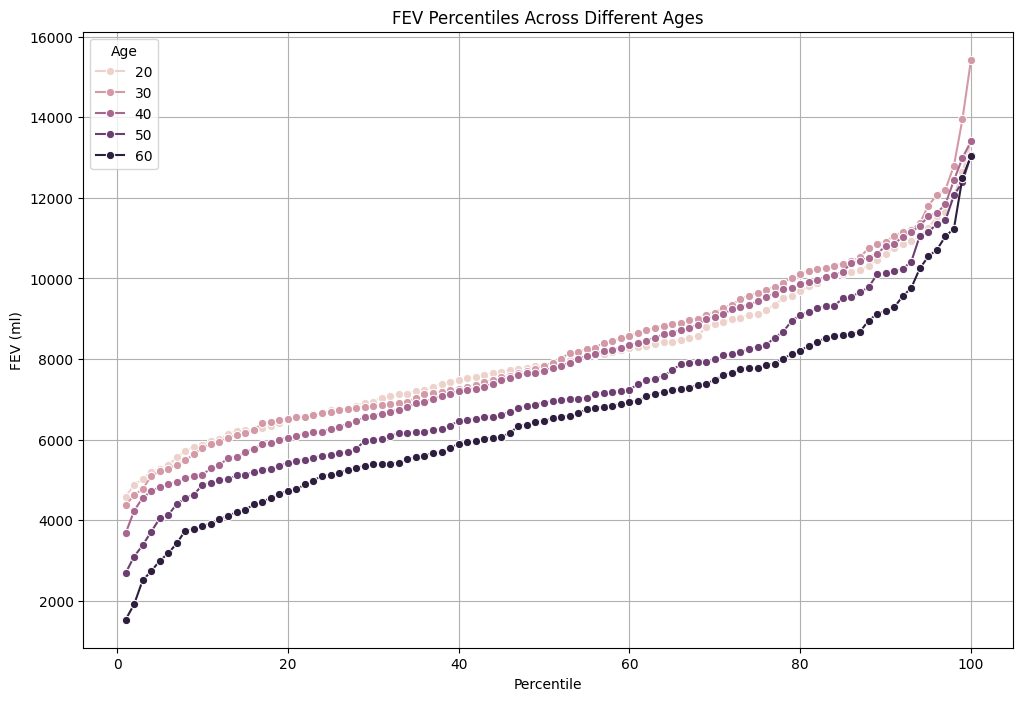

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature = 'Peak expiratory flow, largest value (ml)'
dff = df[[feature, 'gender', 'age']].dropna()

# Computing percentiles within each age group for FEV
# Here we prepare a DataFrame where each column represents an age and each row represents a percentile (0-100)

# Getting unique ages
unique_ages = dff['age'].unique()

# Creating an empty DataFrame for percentiles
percentile_df = pd.DataFrame(index=range(1, 101))  # 1-100 percentiles

for age in unique_ages:
    age_specific_fev = dff[dff['age'] == age][feature]
    percentiles = np.percentile(age_specific_fev, range(1, 101))
    percentile_df[age] = percentiles

# Sorting columns by age for easier interpretation
percentile_df = percentile_df[sorted(percentile_df.columns)]


# Selecting a few age groups for visualization to avoid clutter
selected_ages = [20, 30, 40, 50, 60]

# Creating a new DataFrame for selected ages
selected_percentile_df = percentile_df[selected_ages]

# Melting the DataFrame for easier plotting with seaborn
melted_df = selected_percentile_df.reset_index().melt(id_vars='index', value_vars=selected_ages)
melted_df.rename(columns={'index': 'Percentile', 'variable': 'Age', 'value': 'FEV'}, inplace=True)

# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=melted_df, x='Percentile', y='FEV', hue='Age', marker='o')
plt.title('FEV Percentiles Across Different Ages')
plt.xlabel('Percentile')
plt.ylabel('FEV (ml)')
plt.grid(True)
plt.legend(title='Age')
plt.show()

In [33]:
feature


'Peak expiratory flow, largest value (ml)'

In [49]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

# Define the scope and credentials
scope = ['https://www.googleapis.com/auth/spreadsheets', 'https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name('../ai-curator-416105-3cdafdc34fc8.json', scope)

# Authenticate and open the spreadsheet
gc = gspread.authorize(credentials)
spreadsheet = gc.open(f'{feature}')

# Select the first sheet
worksheet = spreadsheet.get_worksheet(0)

# Update the sheet with DataFrame values
worksheet.update([percentile_df.columns.values.tolist()] + percentile_df.values.tolist())


{'spreadsheetId': '1gYvd7i4Xtwmgl7Tb0iKACM2j-Q6eN0qL_c3i7ABH2uk',
 'updatedRange': 'Sheet1!A1:BU101',
 'updatedRows': 101,
 'updatedColumns': 73,
 'updatedCells': 7373}

In [50]:
credentials

In [47]:
worksheet.

{'spreadsheetId': '1gYvd7i4Xtwmgl7Tb0iKACM2j-Q6eN0qL_c3i7ABH2uk',
 'replies': [{}]}

In [38]:
gc.open_by_key('1gYvd7i4Xtwmgl7Tb0iKACM2j-Q6eN0qL_c3i7ABH2uk')

<Spreadsheet 'Peak expiratory flow, largest value (ml)' id:1gYvd7i4Xtwmgl7Tb0iKACM2j-Q6eN0qL_c3i7ABH2uk>

In [41]:
f'AIKA/bioage_percentiles/Peak expiratory flow, largest value (ml)'


'/AIKA/bioage_percentiles/Peak expiratory flow, largest value (ml)'